In [1]:
!python --version

Python 3.10.13


In [2]:
import torch
torch.__version__

'2.1.2'

In [3]:
!pip install pytorch-ignite

In [4]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import torch.optim as optim
from ignite.handlers import EarlyStopping

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [6]:
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir = "/kaggle/input/intel-image-classification/seg_test/seg_test"

In [7]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
NUM_WORKERS = os.cpu_count()

# Creating DataLoader

In [8]:
def create_dataloader(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir,transform=transform)
    test_data = datasets.ImageFolder(test_dir,transform=transform)
    class_names = train_data.classes
    train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,pin_memory=True)
    test_dataloader = DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=num_workers,pin_memory=True)
    return train_dataloader,test_dataloader,class_names

In [9]:
IMG_SIZE = 224
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                       transforms.ToTensor()])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [10]:
# Set the batch size
BATCH_SIZE = 32 

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloader(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, 
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a4170b4f2b0>,
 ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'])

torch.Size([3, 224, 224]) tensor(1)


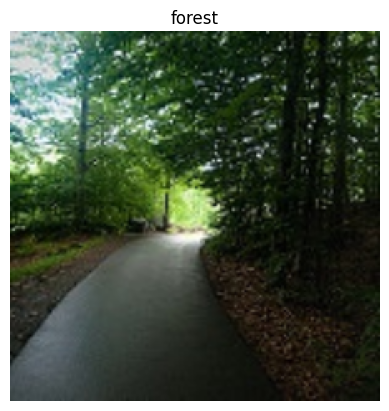

In [11]:
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

# Patch Embedding Layer

In [12]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels=in_channels,out_channels=embedding_dim,
                                 kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
    
    def forward(self,x):
        img_res = x.shape[:-1]
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0,2,1)
        

In [13]:
patch_size = 16
def set_seed(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed()

patches = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patches(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [14]:
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.6460,  0.1674, -0.1587,  ...,  0.5720, -0.3341,  0.3340],
         [-0.7199,  0.1464, -0.2345,  ...,  0.5230, -0.2956,  0.2341],
         [-0.4170,  0.2320, -0.2509,  ...,  0.4283, -0.2348,  0.2709],
         ...,
         [-0.1205, -0.0008, -0.0739,  ...,  0.0822, -0.0292,  0.0497],
         [-0.1135, -0.0017, -0.0710,  ...,  0.0603, -0.0624, -0.0024],
         [-0.0719,  0.0113, -0.0533,  ...,  0.0502, -0.0243,  0.0213]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [61]:
set_seed()

patch_size = 16
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

embedding_layer = PatchEmbedding(in_channels=3,
                 patch_size=16,
                 embedding_dim=768)

patch_embedding = embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

batch_size = patch_embedding.shape[0]
embedding_dim = patch_embedding.shape[-1]
class_token  = nn.Parameter(torch.ones(batch_size,1,embedding_dim),requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")
embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {embedding_class_token.shape}")
num_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, num_patches+1, embedding_dim),
                                  requires_grad=True)
embedding_pos = embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {embedding_pos.shape}")
#patch_and_position_embedding

print(embedding_class_token) 

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [-6.4602e-01,  1.6744e-01, -1.5867e-01,  ...,  5.7198e-01,
          -3.3409e-01,  3.3402e-01],
         [-7.1988e-01,  1.4644e-01, -2.3450e-01,  ...,  5.2296e-01,
          -2.9557e-01,  2.3409e-01],
         ...,
         [-1.2055e-01, -8.4330e-04, -7.3852e-02,  ...,  8.2188e-02,
          -2.9168e-02,  4.9687e-02],
         [-1.1354e-01, -1.6864e-03, -7.0972e-02,  ...,  6.0289e-02,
          -6.2377e-02, -2.4419e-03],
         [-7.1894e-02,  1.1292e-02, -5.3273e-02,  ...,  5.0183e-02,
          -2.4338e-02,  2.1292e-02]]], grad_f

# Creating MuliheadSelfAttention Block

In [62]:
class MultiheadAttentionBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                heads:int=12,
                dropout:float=0):
        super().__init__()
        self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)
        
        self.attn_layer = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=heads,
                                                dropout = dropout,
                                                batch_first=True)
    def forward(self,x):
        x = self.norm_layer(x)
        attn_mask,_ = self.attn_layer(query=x,
                                    key = x,
                                    value=x,
                                    need_weights=False)
        return attn_mask

# Creating Multilevel Perceptron layer

In [63]:
class MLP(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        self.norm_layer = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,out_features=embedding_dim),
            nn.Dropout(p=dropout))
    def forward(self,x):
        x = self.norm_layer(x)
        x = self.mlp(x)
        return x

# Creating Transformer Encoder

In [64]:
class TransformerEncoder(nn.Module):
    def __init__(self,
                 embedding_dim:int=768,
                 heads:int=12,
                 mlp_size:int=3072,
                 mlp_drop:int=0.1,
                 att_drop:int=0):
        super().__init__()
        self.attn_block = MultiheadAttentionBlock(embedding_dim=embedding_dim,
                                                  heads=heads,
                                                  dropout = att_drop)
        self.mlp_block  = MLP(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout = mlp_drop)
    def forward(self, x):
        attn_output = self.attn_block(x)
        x = attn_output[0] + x 
        x = self.mlp_block(x) + x  # Ensure self.mlp_block output is compatible for concatenation with x
        return x
    

In [65]:
trans_encoder_block = TransformerEncoder()

In [66]:
trans_encoder_block

TransformerEncoder(
  (attn_block): MultiheadAttentionBlock(
    (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (attn_layer): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLP(
    (norm_layer): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate='none')
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

In [67]:
import torchinfo
from torchinfo import summary

In [68]:
summary(model=trans_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)       [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadAttentionBlock (attn_block)        [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (attn_layer)        --                   [1, 197, 768]        2,362,368            True
├─MLP (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (norm_layer)                 [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]  

# Creating Vision Transformers from Scratch

In [69]:
class Vit(nn.Module):
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3,
                 patch_size:int=16,
                 num_layers:int=12,
                 embedding_dim:int=768,
                 mlp_size:int=3072,
                 heads:int=12,
                 attn_drop:float=0,
                 mlp_drop:float=0.1, 
                 embedding_drop:float=0.1,
                 num_classes:int=6):
        super().__init__()
        self.patches = (img_size*img_size)//patch_size**2
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),requires_grad=True)
        self.pos_embedding = nn.Parameter(data=torch.randn(1, self.patches+1, embedding_dim),
                                               requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_drop)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        self.transform_encoder = nn.Sequential(*[TransformerEncoder(embedding_dim=embedding_dim,
                                                                    heads=heads,
                                                                    mlp_size=mlp_size,
                                                                    mlp_drop=mlp_drop,
                                                                    att_drop=attn_drop) for i in range(num_layers)])
        self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape=embedding_dim),nn.Linear(in_features=embedding_dim,out_features=num_classes))
    
    def forward(self,x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token,x),dim=1)
        x = self.pos_embedding+x
        x = self.embedding_dropout(x)
        x = self.transform_encoder(x)
        x = self.classifier(x[:,0])
        return x

In [70]:
vit = Vit(num_classes=len(class_names))

In [76]:
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [77]:
from going_modular.going_modular import engine

In [78]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                            lr=3e-2,
                            betas=(0.9,0.99),
                            weight_decay=0.3)
loss_fun = torch.nn.CrossEntropyLoss()
set_seed()
results = engine.train(model=vit,
                      train_dataloader=train_dataloader,
                      test_dataloader=test_dataloader,
                      optimizer = optimizer,
                      loss_fn=loss_fun,
                      epochs=5,
                      device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7941 | train_acc: 0.1690 | test_loss: 1.8025 | test_acc: 0.1838
Epoch: 2 | train_loss: 1.7963 | train_acc: 0.1674 | test_loss: 1.7976 | test_acc: 0.1453
Epoch: 3 | train_loss: 1.7953 | train_acc: 0.1692 | test_loss: 1.7917 | test_acc: 0.1692
Epoch: 4 | train_loss: 1.7956 | train_acc: 0.1675 | test_loss: 1.7937 | test_acc: 0.1745
Epoch: 5 | train_loss: 1.7968 | train_acc: 0.1631 | test_loss: 1.8012 | test_acc: 0.1838


# Training Pretrained vision transformer architecture 

In [17]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# 4. Change the classifier head 
class_names = ['building','forest','glacier','mountain','sea','street']

#pretrained_vit.dropout = nn.Dropout(0.5).to(device)
set_seed()
pretrained_vit.heads = nn.Sequential(
    nn.Dropout(0.25),
    nn.Linear(in_features=768,out_features=512),
    nn.LayerNorm(512),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(in_features=512, out_features=len(class_names))
).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 154MB/s]  


In [20]:
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [21]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [51]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [40]:
import torch
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from ignite.metrics import Accuracy
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator

In [32]:

# Train the classifier head of the pretrained ViT feature extractor model
set_seed()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2875 | train_acc: 0.8914 | test_loss: 0.2308 | test_acc: 0.9135
Epoch: 2 | train_loss: 0.2173 | train_acc: 0.9163 | test_loss: 0.2431 | test_acc: 0.9105
Epoch: 3 | train_loss: 0.1945 | train_acc: 0.9236 | test_loss: 0.2097 | test_acc: 0.9203
Epoch: 4 | train_loss: 0.1836 | train_acc: 0.9324 | test_loss: 0.2019 | test_acc: 0.9224
Epoch: 5 | train_loss: 0.1717 | train_acc: 0.9361 | test_loss: 0.2095 | test_acc: 0.9194
Epoch: 6 | train_loss: 0.1644 | train_acc: 0.9359 | test_loss: 0.2067 | test_acc: 0.9211
Epoch: 7 | train_loss: 0.1569 | train_acc: 0.9382 | test_loss: 0.2003 | test_acc: 0.9293
Epoch: 8 | train_loss: 0.1442 | train_acc: 0.9425 | test_loss: 0.1958 | test_acc: 0.9261
Epoch: 9 | train_loss: 0.1406 | train_acc: 0.9439 | test_loss: 0.2058 | test_acc: 0.9304
Epoch: 10 | train_loss: 0.1405 | train_acc: 0.9443 | test_loss: 0.2039 | test_acc: 0.9262


In [26]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


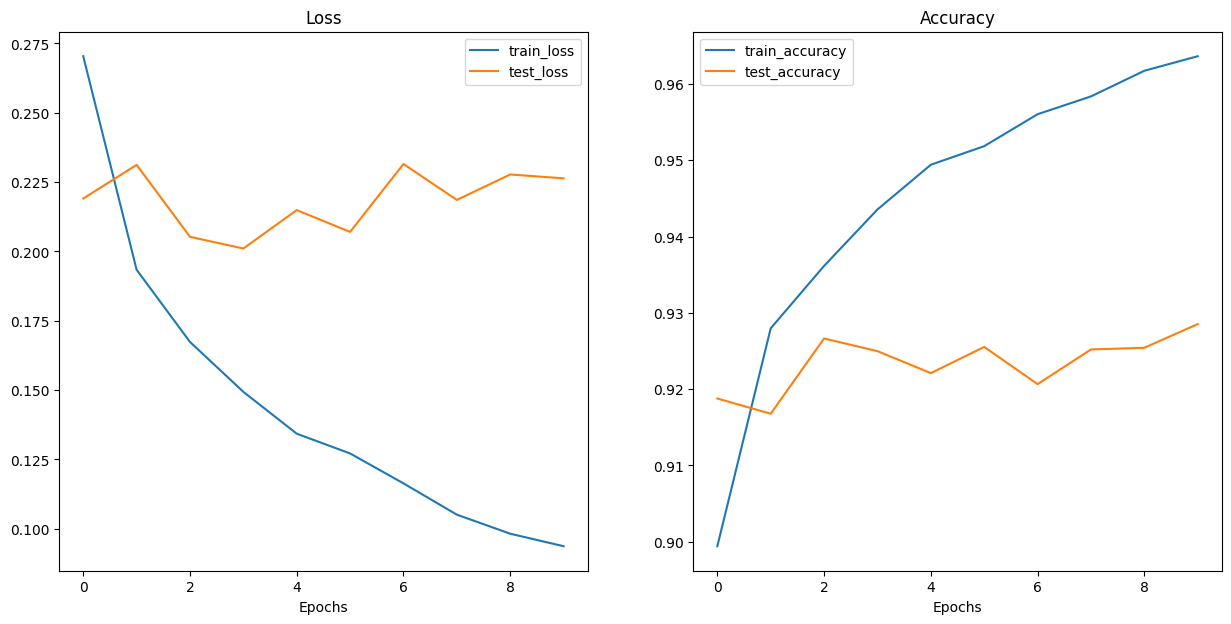

In [27]:
plot_loss_curves(pretrained_vit_results) 

In [54]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping
from ignite.metrics import Loss

# Define the training and evaluation engines
trainer = create_supervised_trainer(pretrained_vit, optimizer, loss_fn, device=device)
evaluator = create_supervised_evaluator(pretrained_vit, metrics={'CrossEntropy': Loss(loss_fn)}, device=device)

# Define the early stopping criteria
handler = EarlyStopping(patience=3, score_function=lambda engine: -engine.state.metrics['CrossEntropy'], trainer=trainer)
evaluator.add_event_handler(Events.COMPLETED, handler)

# Assuming you have training and validation dataloaders: train_dataloader and val_dataloader
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_dataloader)
    metrics = evaluator.state.metrics
    print(f"Training Results - Epoch: {engine.state.epoch}  Avg loss: {metrics['CrossEntropy']}")

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(test_dataloader)
    metrics = evaluator.state.metrics
    print(f"Validation Results - Epoch: {engine.state.epoch}  Avg loss: {metrics['CrossEntropy']}")

# Run the trainer for 10 epochs
trainer.run(train_dataloader, max_epochs=10)


Training Results - Epoch: 1  Avg loss: 0.1261648259917878
Validation Results - Epoch: 1  Avg loss: 0.20245037841796876
Training Results - Epoch: 2  Avg loss: 0.11805080344776525
Validation Results - Epoch: 2  Avg loss: 0.20230450439453124
Training Results - Epoch: 3  Avg loss: 0.10354652964730743
Validation Results - Epoch: 3  Avg loss: 0.19904111735026042
Training Results - Epoch: 4  Avg loss: 0.10923669887638948


2024-04-17 07:17:49,458 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch: 4  Avg loss: 0.20509993489583334


State:
	iteration: 1756
	epoch: 4
	epoch_length: 439
	max_epochs: 10
	output: 0.11114399880170822
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>